## 5-2. Quantum Circuit learning

**Quantum Circuit Learning** (量子回路学習, QCL)は、量子コンピュータを機械学習に応用するためのアルゴリズムである[[1]](https://arxiv.org/abs/1803.00745)。  
前節で学んだVQE (Variational Quantum Eigensolver)と同様、**量子・古典ハイブリッドアルゴリズム**であり、誤り訂正機能を持たない中規模の量子コンピュータである**NISQ** (Noisy Intermediate-Scale Quantum Computer)での動作を念頭に設計されている。実際のNISQデバイスを用いた実験もすでに行われており、2019年3月にIBMの実験チームによるQCLの実機実装論文[[2]](https://www.nature.com/articles/s41586-019-0980-2)がNatureに掲載され話題となった。

以下では、まずアルゴリズムの概要と具体的な学習の手順を紹介し、最後に量子シミュレータQulacsを用いた実装例を提示する。

### QCLの概要

近年、機械学習の分野においてディープラーニングが脚光を浴びている。  
ディープラーニングにおいては深い**ニューラルネットワーク**を用いて複雑な関数の近似を行うことで、入力と出力の関係を学習し、新しいデータに対して予測を行う事ができる。  

QCLは、このニューラルネットワークを**量子回路**、すなわち量子コンピュータに置き換えた機械学習手法である。量子回路を用いることで、量子力学の重ね合わせの原理を生かして**指数関数的に多数の基底関数**を用いて学習できるため、モデルの表現力が向上する。さらに、量子回路の満たすべき条件（ユニタリ性）により、**自動的にoverfittingを防げる**と考えられている。これにより、古典コンピュータにおける機械学習を超える、さらなる高性能化が期待できる。   
（詳細は参考文献[1]を参照のこと）

ニューラルネットワークにおいては、各層の重みパラメータ$W$を調整することで関数の近似を行っているが、QCLにおいても考え方は全く同様である。  
すなわち、QCLで用いる量子回路には複数の「回転ゲート」が含まれているが、この回転ゲートの回転角$\theta$を調整することで、関数の近似を行うのである。具体的な手順を以下に示す。

### 学習の手順
1. 学習データ $\{(x_i, y_i)\}_i$ を用意する（$x_i$は入力データ、$y_i$は$x_i$から予測したい正解データ（教師データ））
2. $U_{\text{in}}(x)$という、入力$x$から何らかの規則で決まる回路を用意し、$x_i$の情報を埋め込んだ入力状態$\{|\psi_{\rm in}(x_i)\rangle\}_i = \{U_{\text{in}}(x_i)|0\rangle\}_i$ を作る
3. 入力状態に、パラメータ$\theta$に依存したゲート$U(\theta)$を掛けたものを出力状態$\{|\psi_{\rm out}(x_i, \theta)\rangle = U(\theta)|\psi_{\rm in}(x_i)\rangle  \}_i$とする
4. 出力状態のもとで何らかのオブザーバブルを測定し、測定値を得る（例：1番目のqubitの$Z$の期待値$\langle Z_1\rangle = \langle \psi_{\rm out} |Z_1|\psi_{\rm out} \rangle$）
5. $F$を適当な関数（sigmoidとかsoftmaxとか定数倍とか何でもいい）として、$F(測定値_i)$をモデルの出力$y(x_i, \theta)$とする
6. 正解データ$\{y_i\}_i$とモデルの出力$\{y(x_i, \theta)\}_i$の間の乖離を表す「コスト関数$L(\theta)$」を計算する
7. コスト関数を最小化する$\theta=\theta^*$を求める
8. $y(x, \theta^*)$が、所望の予測モデルである


![QCL](figs/5/QCL.png)
(QCLでは、入力データ $x$ をまず$U_{\text{in}}(x)$を用いて量子状態に変換し、そこから変分量子回路$U(\theta)$と測定等を用いて出力$y$を得る（図では出力は$\langle B(x,\theta)\rangle$）。出典：参考文献[1]の図1を改変）

### 量子シミュレータQulacsを用いた実装

以下では関数の近似のデモンストレーションとして、sin関数 $y=\sin(\pi x)$ のフィッティングを行う。

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

In [31]:
########  パラメータ  #############
nqubit = 3 ## qubitの数
c_depth = 3 ## circuitの深さ
time_step = 0.77  ## ランダムハミルトニアンによる時間発展の経過時間

## [x_min, x_max]のうち, ランダムにnum_x_train個の点をとって教師データとする.
x_min = - 1.; x_max = 1.;
num_x_train = 50

## 学習したい1変数関数
func_to_learn = lambda x: np.sin(x*np.pi)

## 乱数のシード
random_seed = 0
## 乱数発生器の初期化
np.random.seed(random_seed)

#### 学習データの準備

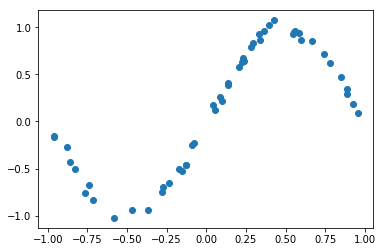

In [32]:
#### 教師データを準備
x_train = x_min + (x_max - x_min) * np.random.rand(num_x_train)
y_train = func_to_learn(x_train)

# 現実のデータを用いる場合を想定し、きれいなsin関数にノイズを付加
mag_noise = 0.05
y_train = y_train + mag_noise * np.random.randn(num_x_train)

plt.plot(x_train, y_train, "o"); plt.show()

#### 入力状態の構成
まず、入力値$x_i$を初期状態$|00\ldots0\rangle$に埋め込むためのゲート $U_{\rm in}(x_i)$を作成する。   
参考文献[1]に従い、回転ゲート$R_j^X(\theta)=e^{i\theta X_j/2}, R_j^Z(\theta)=e^{i\theta Z_j/2}$を用いて$U_{\rm in}(x) = \prod_j R^Z_j(\cos^{-1} x^2) R^Y_j(\sin^{-1}x)$と定義する。   
入力値$x_i$は、$|\psi_{\rm in}(x_i)\rangle =U_{\rm in}(x_i)|00\ldots0\rangle$ という量子状態に変換されることになる。

In [ ]:
## Google Colaboratoryの場合・Qulacsがインストールされていないlocal環境の場合のみ実行してください
!pip install qulacs

In [33]:
# 初期状態の作成
from qulacs import QuantumState, QuantumCircuit

state = QuantumState(nqubit) # 初期状態 |000>
state.set_zero_state()
print(state.get_vector())

[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]


In [34]:
# xをエンコードするゲートを作成する関数
def U_in(x):
    U = QuantumCircuit(nqubit)
    
    angle_y = np.arcsin(x)
    angle_z = np.arccos(x**2)

    for i in range(nqubit):
        U.add_RY_gate(i, angle_y)
        U.add_RZ_gate(i, angle_z)
    
    return U

In [35]:
# 入力状態を試す
x = 0.1 # 適当な値
U_in(x).update_quantum_state(state) # U_in|000>の計算
print(state.get_vector())

[-6.93804351e-01+7.14937415e-01j -3.54871219e-02-3.51340074e-02j
 -3.54871219e-02-3.51340074e-02j  1.77881430e-03-1.76111422e-03j
 -3.54871219e-02-3.51340074e-02j  1.77881430e-03-1.76111422e-03j
  1.77881430e-03-1.76111422e-03j  8.73809020e-05+9.00424970e-05j]


#### 変分量子回路$U(\theta)$の構成
次に、最適化すべき変分量子回路$U(\theta)$を作っていく。これは以下の３手順で行う。

1. 横磁場イジングハミルトニアン作成
2. 回転ゲート作成
3. 1.と2.のゲートを交互に組み合わせ、1つの大きな変分量子回路$U(\theta)$を作る

##### 1. 横磁場イジングハミルトニアン作成
4-2節で学んだ横磁場イジングモデルによる時間発展を行い量子回路の複雑性（エンタングルメント）を増すことで、モデルの表現力を高める。（本パートは、詳細を知りたい読者以外は読み飛ばしていただいて構わない。）   

横磁場イジングモデルのハミルトニアンは以下の通りで、$U_{\text{rand}} = e^{-iHt}$という時間発展演算子を定義する。

$$
H = \sum_{j=1}^N a_j X_j + \sum_{j=1}^N \sum_{k=1}^{j-1} J_{jk} Z_j Z_k
$$

ここで係数$a$, $J$は$[-1, 1]$の一様分布である。

In [36]:
## 基本ゲート
from qulacs.gate import X, Z
I_mat = np.eye(2, dtype=complex)
X_mat = X(0).get_matrix()
Z_mat = Z(0).get_matrix()

In [37]:
## fullsizeのgateをつくる関数.
def make_fullgate(list_SiteAndOperator, nqubit):
    '''
    list_SiteAndOperator = [ [i_0, O_0], [i_1, O_1], ...] を受け取り,
    関係ないqubitにIdentityを挿入して
    I(0) * ... * O_0(i_0) * ... * O_1(i_1) ...
    という(2**nqubit, 2**nqubit)行列をつくる.
    '''
    list_Site = [SiteAndOperator[0] for SiteAndOperator in list_SiteAndOperator]
    list_SingleGates = [] ## 1-qubit gateを並べてnp.kronでreduceする
    cnt = 0
    for i in range(nqubit):
        if (i in list_Site):
            list_SingleGates.append( list_SiteAndOperator[cnt][1] )
            cnt += 1
        else: ## 何もないsiteはidentity
            list_SingleGates.append(I_mat)

    return reduce(np.kron, list_SingleGates)

In [38]:
#### ランダム磁場・ランダム結合イジングハミルトニアンをつくって時間発展演算子をつくる
ham = np.zeros((2**nqubit,2**nqubit), dtype = complex)
for i in range(nqubit): ## i runs 0 to nqubit-1
    Jx = -1. + 2.*np.random.rand() ## -1~1の乱数
    ham += Jx * make_fullgate( [ [i, X_mat] ], nqubit)
    for j in range(i+1, nqubit):
        J_ij = -1. + 2.*np.random.rand()
        ham += J_ij * make_fullgate ([ [i, Z_mat], [j, Z_mat]], nqubit)

## 対角化して時間発展演算子をつくる. H*P = P*D <-> H = P*D*P^dagger
diag, eigen_vecs = np.linalg.eigh(ham)
time_evol_op = np.dot(np.dot(eigen_vecs, np.diag(np.exp(-1j*time_step*diag))), eigen_vecs.T.conj()) # e^-iHT

In [39]:
time_evol_op.shape

(8, 8)

In [40]:
# qulacsのゲートに変換しておく
from qulacs.gate import DenseMatrix
time_evol_gate = DenseMatrix([i for i in range(nqubit)], time_evol_op)

##### 2. 回転ゲート作成、3. $U(θ)$の構成

先ほど構成したランダム横磁場イジングモデルによる時間発展$U_{\text{rand}}$と、
$j \:(=1,2,\cdots n)$番目の量子ビットに回転ゲート

$$
U_{\text{rot}}(\theta_j^{(i)}) = R_j^X(\theta_{j1}^{(i)})R_j^Z(\theta_{j2}^{(i)})R_j^X(\theta_{j3}^{(i)})
$$

をかけたものを組み合わせて変分量子回路$U(\theta)$を構成する。   ここで$i$は量子回路の層を表す添字で、$U_{\text{rand}}$と上記の回転を合計$d$層繰り返す。   
つまり全体では、

$$
 U \left( \{ \theta_j^{(i)} \}_{i,j} \right) = \prod_{i=1}^d \left( \left( \prod_{j=1}^n U_{\text{rot}}(\theta_j^{(i)})\right) \cdot U_{\text{rand}} \right)
$$

という変分量子回路を用いる。全部で $3nd$ 個のパラメータがあることになる。各$\theta$の初期値は$[0, 2\pi]$の一様分布にとっておく。

In [41]:
from qulacs import ParametricQuantumCircuit

In [42]:
# output用ゲートU_outの組み立て&パラメータ初期値の設定
U_out = ParametricQuantumCircuit(nqubit)
for d in range(c_depth):
    U_out.add_gate(time_evol_gate)
    for i in range(nqubit):
        angle = 2.0 * np.pi * np.random.rand()
        U_out.add_parametric_RX_gate(i,angle)
        angle = 2.0 * np.pi * np.random.rand()
        U_out.add_parametric_RZ_gate(i,angle)
        angle = 2.0 * np.pi * np.random.rand()
        U_out.add_parametric_RX_gate(i,angle)

In [43]:
# パラメータthetaの初期値のリストを取得しておく
parameter_count = U_out.get_parameter_count()
theta_init = [U_out.get_parameter(ind) for ind in range(parameter_count)]

In [44]:
theta_init

[6.007250646127814,
 4.046309757767312,
 2.663159813474645,
 3.810080933381979,
 0.12059442161498848,
 1.8948504571449056,
 4.14799267096281,
 1.8226113595664735,
 3.88310546309581,
 2.6940332019609157,
 0.851208649826403,
 1.8741631278382846,
 3.5811951525261123,
 3.7125630518871535,
 3.6085919651139333,
 4.104181793964002,
 4.097285684838374,
 2.71068197476515,
 5.633168398253273,
 2.309459341364396,
 2.738620094343915,
 5.6041197193647925,
 5.065466226710866,
 4.4226624059922806,
 0.6297441057449945,
 5.777279648887616,
 4.487710439107831]

後の便利のため、$U(\theta)$のパラメータ$\theta$を更新する関数を作成しておく。

In [45]:
# パラメータthetaを更新する関数
def set_U_out(theta):    
    global U_out
    
    parameter_count = U_out.get_parameter_count()
    
    for i in range(parameter_count):
        U_out.set_parameter(i, theta[i])

#### 測定
今回は、0番目の量子ビットのpauli Zの、出力状態$|\psi_{\rm out}\rangle$での期待値をモデルの出力とする。   
すなわち、$y(\theta, x_i) = \langle Z_0 \rangle = \langle \psi_{\rm out}|Z_0|\psi_{\rm out}\rangle$である。

In [46]:
# オブザーバブルZ_0を作成
from qulacs import Observable
obs = Observable(nqubit)
obs.add_operator(2.,'Z 0') # オブザーバブル2 * Zを設定。ここで2を掛けているのは、最終的な<Z>の値域を広げるためである。未知の関数に対応するためには、この定数もパラメータの一つとして最適化する必要がある。

In [47]:
obs.get_expectation_value(state)

1.9899748742132404

#### 一連の流れを関数にまとめる
ここまでの流れをまとめて、入力$x_i$からモデルの予測値$y(x_i, \theta)$を返す関数を定義する。

In [48]:
# 入力x_iからモデルの予測値y(x_i, theta)を返す関数
def qcl_pred(x, U_out):
    state = QuantumState(nqubit)
    state.set_zero_state()
    
    # 入力状態計算
    U_in(x).update_quantum_state(state)
    
    # 出力状態計算
    U_out.update_quantum_state(state)
    
    # モデルの出力
    res = obs.get_expectation_value(state)
    
    return res

#### コスト関数計算
コスト関数 $L(\theta)$は、教師データと予測データの平均二乗誤差(MSE)とする。

In [49]:
# cost function Lを計算
def cost_func(theta):
    '''
    theta: 長さc_depth * nqubit * 3のndarray
    '''
    # U_outのパラメータthetaを更新
#     global U_out
    set_U_out(theta)
    
    # num_x_train個のデータについて計算
    y_pred = [qcl_pred(x, U_out) for x in x_train]
    
    # quadratic loss
    L = ((y_pred - y_train)**2).mean()
    
    return L

In [50]:
# パラメータthetaの初期値におけるコスト関数の値
cost_func(theta_init)

1.3889259316193516

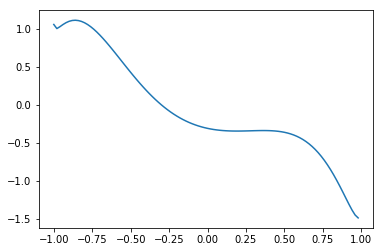

In [51]:
# パラメータthetaの初期値のもとでのグラフ
xlist = np.arange(x_min, x_max, 0.02)
y_init = [qcl_pred(x, U_out) for x in xlist]
plt.plot(xlist, y_init)

#### 学習（scipy.optimize.minimizeで最適化）
ようやく準備が終わり、いよいよ学習を行う。ここでは簡単のため、勾配の計算式を与える必要のないNelder-Mead法を用いて最適化する。勾配を用いる最適化手法（例：BFGS法）を用いる場合は、勾配の便利な計算式が参考文献[[1]](https://arxiv.org/abs/1803.00745)で紹介されているので参照されたい。

In [52]:
from scipy.optimize import minimize

In [53]:
%%time
# 学習 (筆者のPCで1~2分程度かかる)
result = minimize(cost_func, theta_init, method='Nelder-Mead') 

Wall time: 1min 21s


In [54]:
# 最適化後のcost_functionの値
result.fun 

0.003987076559624744

In [55]:
# 最適化によるthetaの解
theta_opt = result.x 
print(theta_opt)

[7.17242144 5.4043736  1.27744316 3.09192904 0.13144047 2.13757354
 4.58470259 2.01924008 2.96107066 2.91843537 1.0609229  1.70351774
 6.41114609 6.25686828 2.41619471 3.69387805 4.07551328 1.47666316
 3.4108701  2.28524042 1.75253621 6.47969129 3.18418337 1.58699008
 1.2831137  4.82903335 5.95931349]


#### 結果のプロット

In [56]:
# U_outに最適化されたthetaを代入
set_U_out(theta_opt)

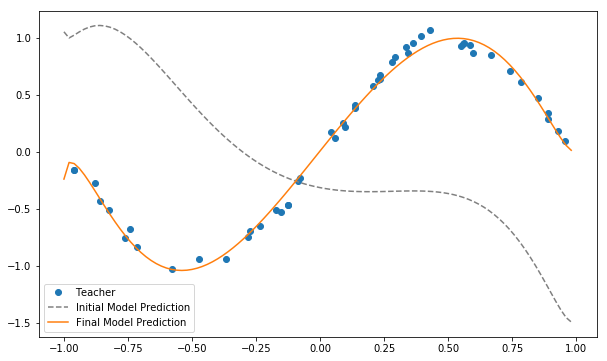

In [57]:
# プロット
plt.figure(figsize=(10, 6))

xlist = np.arange(x_min, x_max, 0.02)

# 教師データ
plt.plot(x_train, y_train, "o", label='Teacher')

# パラメータθの初期値のもとでのグラフ
plt.plot(xlist, y_init, '--', label='Initial Model Prediction', c='gray')

# モデルの予測値
y_pred = np.array([qcl_pred(x, U_out) for x in xlist])
plt.plot(xlist, y_pred, label='Final Model Prediction')

plt.legend()
plt.show()

確かにsin関数の近似に成功している事がわかる。  
ここでは入力・出力ともに1次元の関数の近似という極めてシンプルなタスクを扱ったが、より多次元の入出力をもつ関数の近似や分類問題にも拡張が可能である。   
意欲のある読者は、コラム ``5.2c.Application of QCL to Machine Learning`` において、代表的な機械学習のデータセットの一つである[Irisデータセット](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html)の分類に挑戦されたい。

### 参考文献
[1] K. Mitarai, M. Negoro, M. Kitagawa, and K. Fujii, “Quantum circuit learning”, [Phys. Rev. A 98, 032309 (2018)](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.98.032309), arXiv版：https://arxiv.org/abs/1803.00745  
[2] V. Havlicek _et al._ , “Supervised learning with quantum-enhanced feature spaces”, [Nature 567, 209–212 (2019)](https://www.nature.com/articles/s41586-019-0980-2), arXiv版：https://arxiv.org/abs/1804.11326